In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

import os
import torch
import matplotlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from src.utils.parser import get_config
from matplotlib.animation import FuncAnimation
from src.datasets.dhf1k_dataset import DHF1KDataModule
from src.datasets.salicon_dataset import SaliconDataModule
from src.lightning_models.lightning_model import LightningModel

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

from src.models.livesal import LiveSAL
from src.utils.file import get_paths_recursive
from src.config import (
    SEED,
    DEVICE,
    N_WORKERS,
    CONFIG_PATH,
    MODELS_PATH,
    SEQUENCE_LENGTH,
    PROCESSED_DHF1K_PATH,
    PROCESSED_SALICON_PATH,
    CHECKPOINTS_PATH,
    FINAL_HEIGHT,
    FINAL_WIDTH,
)

STATE_FILE_PATH = f"{CHECKPOINTS_PATH}/livesal_temporal_dhf1k.ckpt"
CONFIG_FILE_PATH = f"{CONFIG_PATH}/livesal/temporal_dhf1k.yml"

c:\Users\arnau\anaconda3\envs\pdm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config = get_config(CONFIG_FILE_PATH)
dataset = str(config["dataset"])
n_epochs = int(config["n_epochs"])
learning_rate = float(config["learning_rate"])
weight_decay = float(config["weight_decay"])
batch_size = int(config["batch_size"])
evaluation_steps = int(config["evaluation_steps"])
splits = tuple(map(float, config["splits"]))
use_challenge_split = bool(config["use_challenge_split"])
save_model = bool(config["save_model"])
with_transforms = bool(config["with_transforms"])
image_n_levels = int(config["image_n_levels"])
hidden_channels = int(config["hidden_channels"])
neighbor_radius = int(config["neighbor_radius"])
n_iterations = int(config["n_iterations"])
image_hidden_channels_list = list(map(int, config["image_hidden_channels_list"]))
depth_hidden_channels_list = list(map(int, config["depth_hidden_channels_list"]))
freeze_encoder = bool(config["freeze_encoder"])
freeze_temporal_pipeline = bool(config["freeze_temporal_pipeline"])
output_type = str(config["output_type"])
dropout_rate = float(config["dropout_rate"])
with_graph_processing = bool(config["with_graph_processing"])
with_graph_edge_features = bool(config["with_graph_edge_features"])
with_graph_positional_embeddings = bool(config["with_graph_positional_embeddings"])
with_graph_directional_kernels = bool(config["with_graph_directional_kernels"])
with_depth_information = bool(config["with_depth_information"])
with_checkpoint = bool(config["with_checkpoint"])
train_split = splits[0]
val_split = splits[1]
test_split = splits[2]

In [4]:
if dataset == "salicon":
    data_module = SaliconDataModule(
        batch_size=batch_size,
        train_split=train_split,
        val_split=val_split,
        test_split=test_split,
        use_challenge_split=use_challenge_split,
        with_transforms=with_transforms,
        n_workers=N_WORKERS,
        seed=SEED,
    )
elif dataset == "dhf1k":
    sample_folder_paths = get_paths_recursive(
        folder_path=PROCESSED_DHF1K_PATH, match_pattern="*", path_type="d"
    )
    data_module = DHF1KDataModule(
        sample_folder_paths=sample_folder_paths,
        batch_size=batch_size,
        train_split=train_split,
        val_split=val_split,
        test_split=test_split,
        with_transforms=with_transforms,
        n_workers=N_WORKERS,
        seed=SEED,
    )
data_module.setup("test")
data_module.setup("fit")
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

Seed set to 0


🌱 Setting the seed to 0 for generating dataloaders.


Seed set to 0


🌱 Setting the seed to 0 for generating dataloaders.


In [6]:
model = LiveSAL(
    image_n_levels=image_n_levels,
    freeze_encoder=freeze_encoder,
    freeze_temporal_pipeline=freeze_temporal_pipeline,
    hidden_channels=hidden_channels,
    neighbor_radius=neighbor_radius,
    n_iterations=n_iterations,
    image_hidden_channels_list=image_hidden_channels_list,
    depth_hidden_channels_list=depth_hidden_channels_list,
    output_type=output_type,
    dropout_rate=dropout_rate,
    with_graph_processing=with_graph_processing,
    with_graph_edge_features=with_graph_edge_features,
    with_graph_positional_embeddings=with_graph_positional_embeddings,
    with_graph_directional_kernels=with_graph_directional_kernels,
    with_depth_information=with_depth_information,
)
lightning_model = LightningModel.load_from_checkpoint(
    checkpoint_path=STATE_FILE_PATH,
    model=model,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    name="livesal",
    dataset=dataset,
)

In [5]:
matplotlib.use("TkAgg")

def visualize_batches(lightning_model, dataloader, interval=500):
    lightning_model.eval()
    lightning_model = lightning_model.to(DEVICE)
    
    # Create iterator
    dataloader_iter = iter(dataloader)
    
    # Create figure and axes
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    plt.subplots_adjust(bottom=0.2)  # Make room for button
    
    # Global variables to store current batch data
    current_batch = None
    anim = None
    
    def process_batch():
        frame, ground_truths, global_ground_truth, _ = next(dataloader_iter)
        print(frame.shape)
        input = frame.to(DEVICE)
        with torch.no_grad():
            output, _ = lightning_model.model(input)
            output_min = output.min()
            output_max = output.max()
            if output_min < output_max:
                output = (output - output_min) / (output_max - output_min)

        if output.dim() == 3:
            output = output.unsqueeze(1)

        if output.shape[1] == 1:
            ground_truth = global_ground_truth.unsqueeze(1).to(DEVICE)
        else:
            ground_truth = ground_truths.to(DEVICE)
        
        return input, output, ground_truth
    
    def init_animation():
        ax1.clear()
        ax2.clear()
        ax3.clear()
        return ax1, ax2, ax3

    def animate(frame_idx):
        ax1.clear()
        ax2.clear()
        ax3.clear()
        
        input, output, ground_truths = current_batch
        
        # Get the first sample of the sequence for the current frame
        if input.dim() == 4:
            input_frame = input[0]
        elif input.dim() == 5:
            input_frame = input[0, frame_idx]
        output_frame = output[0, frame_idx]
        gt_frame = ground_truths[0, frame_idx]
        
        # Process input frame for visualization
        input_np = input_frame.permute(1, 2, 0).cpu().detach().numpy()
        
        # Process output and ground truth
        output_np = output_frame.cpu().detach().numpy()
        gt_np = gt_frame.cpu().detach().numpy()
        
        # Display frames
        ax1.imshow(input_np)
        ax2.imshow(output_np, cmap="jet", vmin=0, vmax=1)
        ax3.imshow(gt_np, cmap="jet", vmin=0, vmax=1)
        
        ax1.set_title(f'Input (Sequence {frame_idx + 1}/3)')
        ax2.set_title(f'Output (Sequence {frame_idx + 1}/3)')
        ax3.set_title(f'Ground Truth (Sequence {frame_idx + 1}/3)')
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        
        return ax1, ax2, ax3
    
    def update_plot(event=None):
        nonlocal current_batch, anim
        
        try:
            # Get new batch
            current_batch = process_batch()
            
            # If there's an existing animation, stop it
            if anim is not None:
                anim.event_source.stop()
            
            # Create new animation
            anim = FuncAnimation(
                fig, 
                animate, 
                init_func=init_animation,
                frames=SEQUENCE_LENGTH,
                interval=interval,
                repeat=True,
                blit=True
            )
            
        except StopIteration:
            print("Reached the end of the dataset. Restarting...")
            nonlocal dataloader_iter
            dataloader_iter = iter(dataloader)
            update_plot()
        
        fig.canvas.draw_idle()
    
    # Add button
    ax_button = plt.axes([0.4, 0.05, 0.2, 0.075])
    button = Button(ax_button, 'Next Batch')
    button.on_clicked(update_plot)
    
    # Show initial batch
    update_plot()
    
    plt.show(block=True)

visualize_batches(lightning_model, test_loader, interval=500)

NameError: name 'lightning_model' is not defined

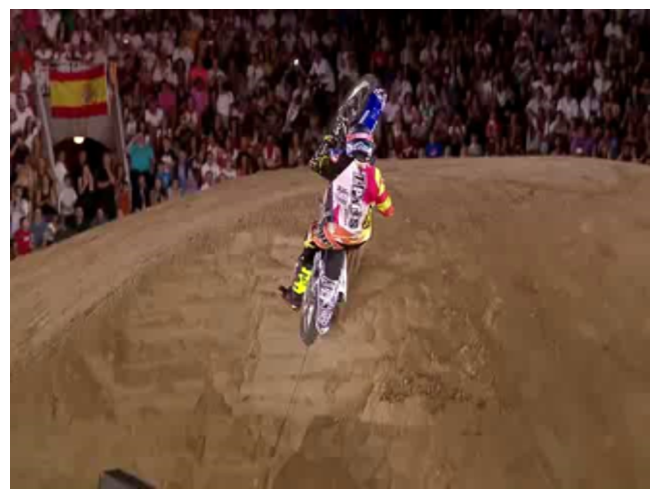

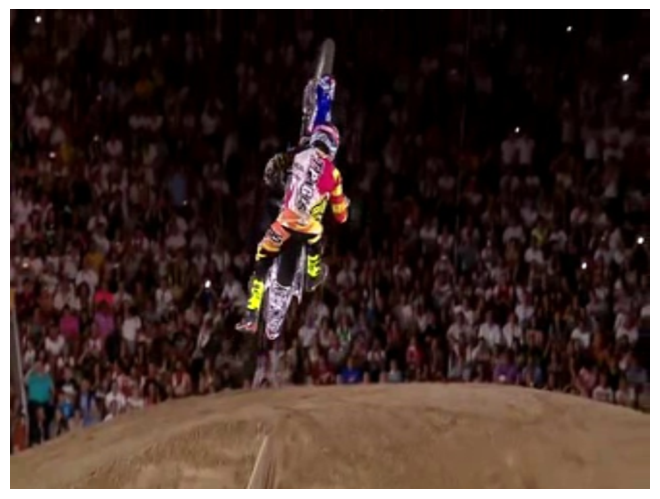

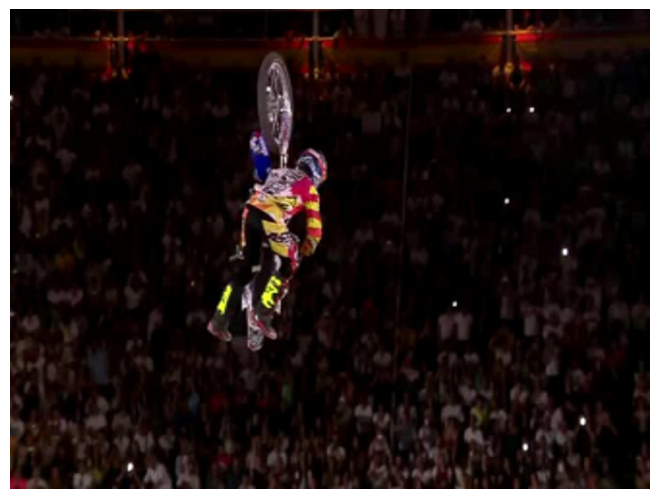

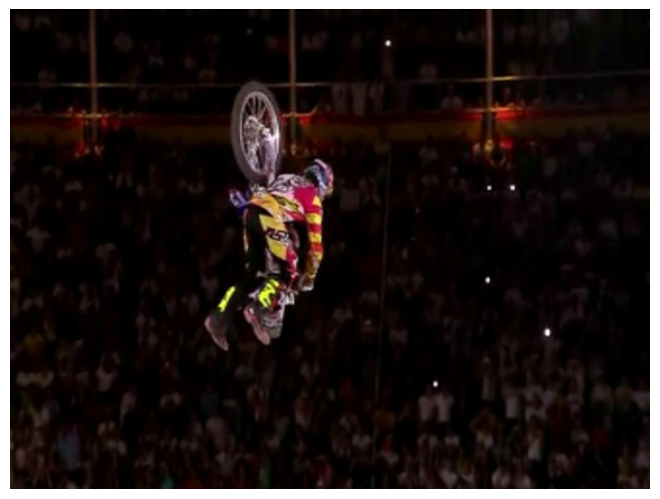

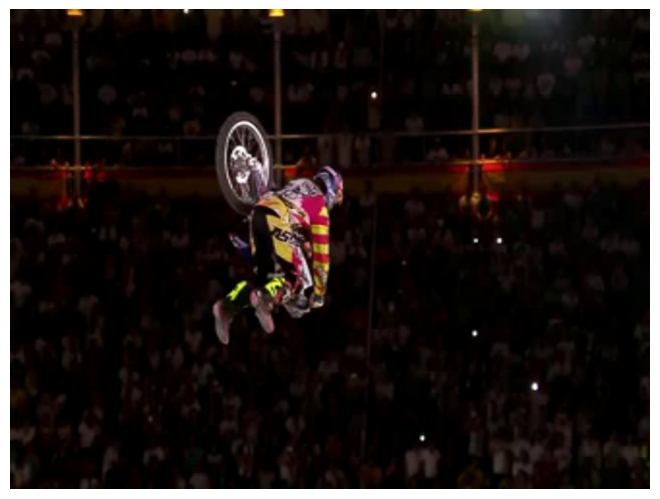

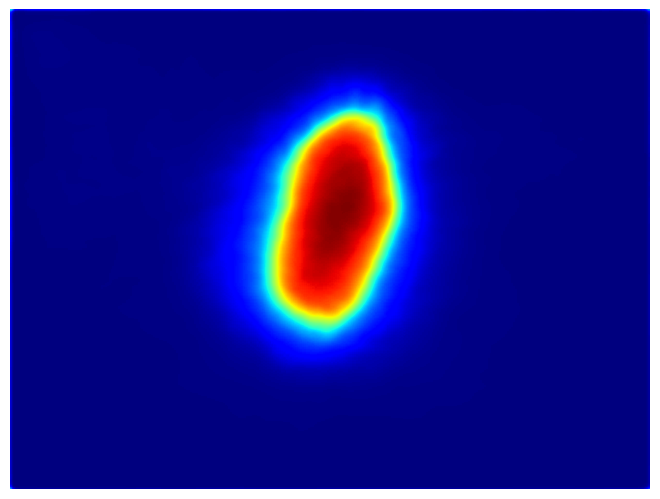

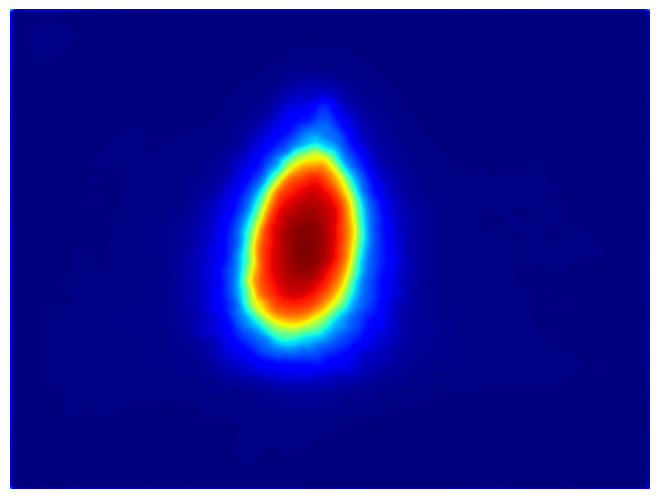

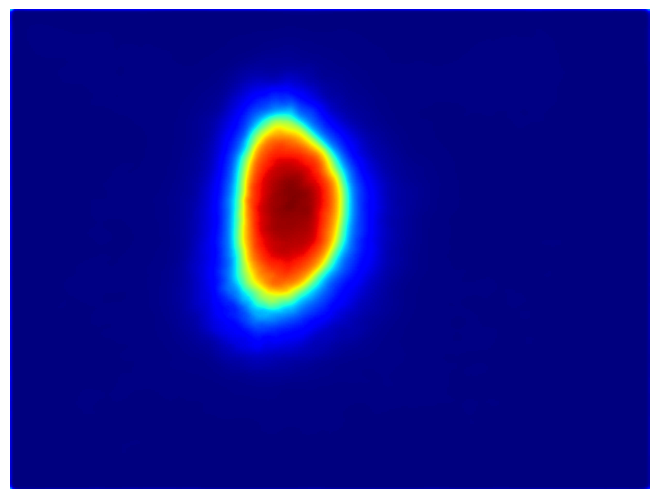

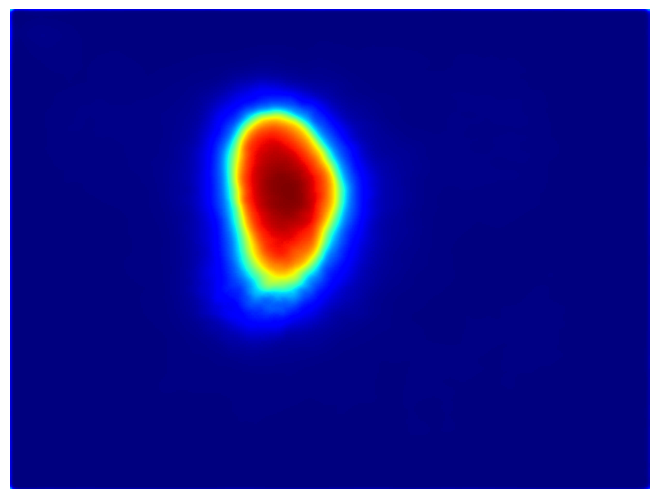

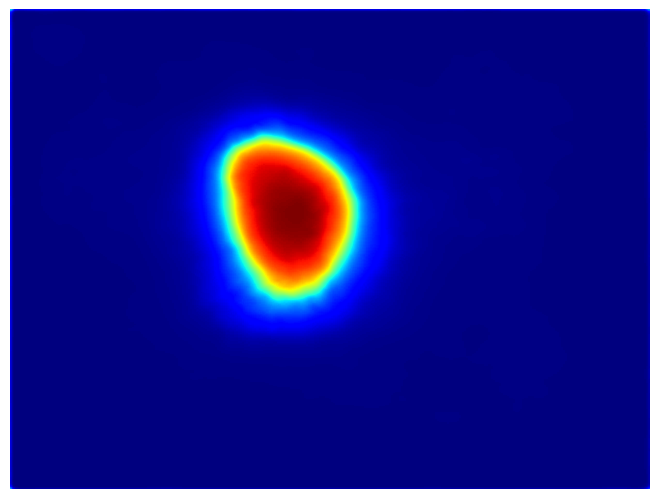

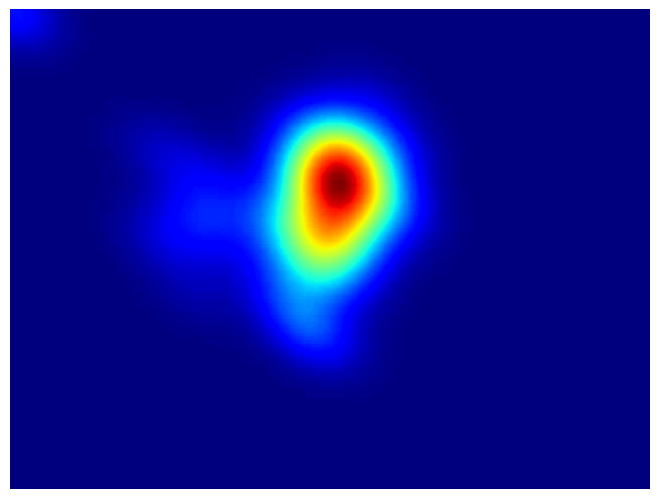

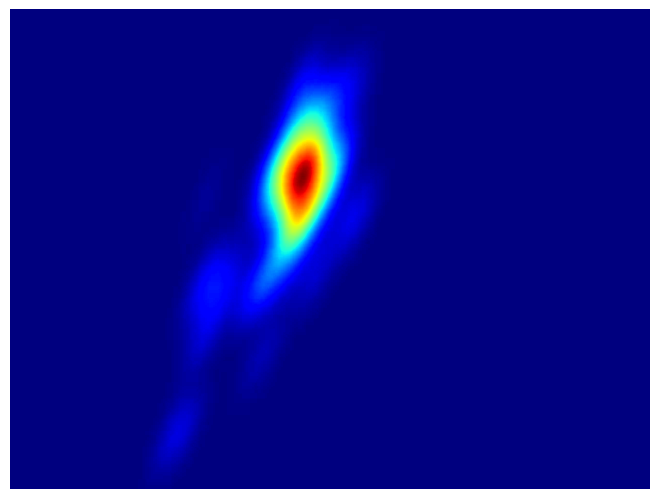

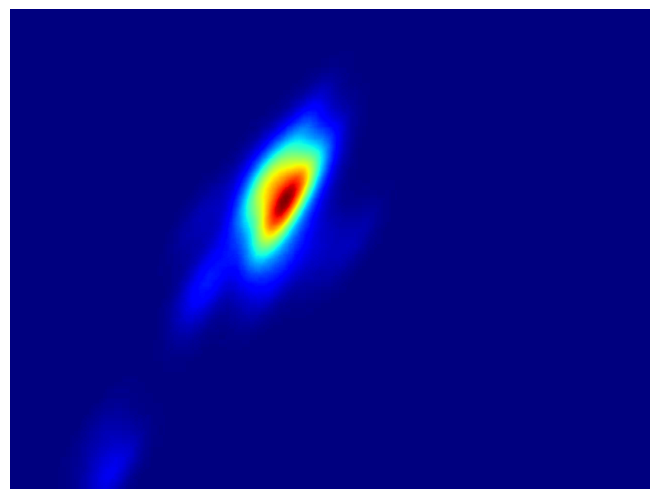

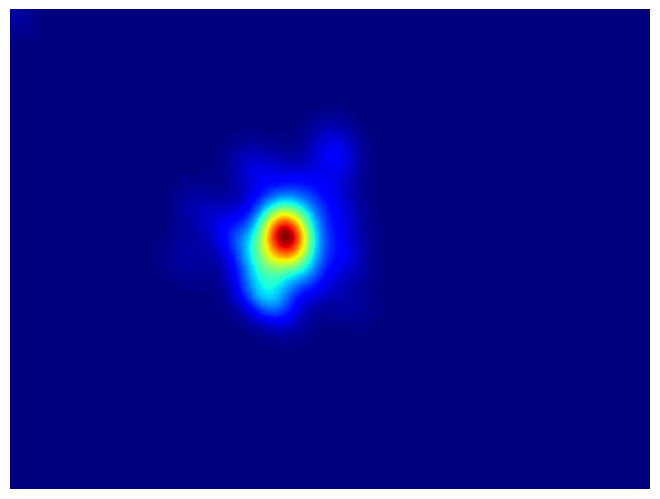

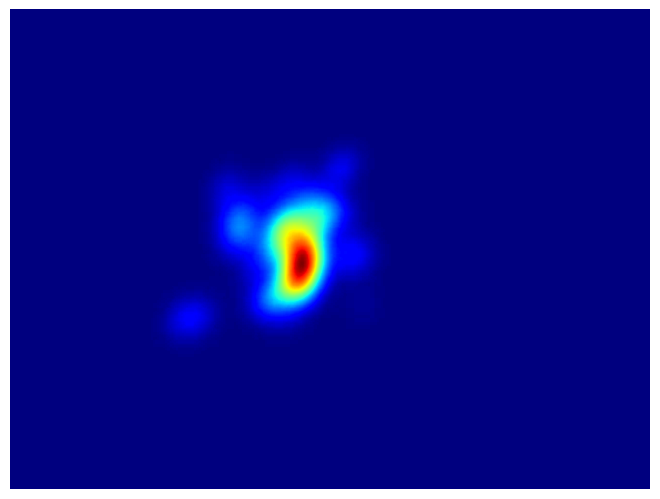

In [81]:
matplotlib.use('inline')

def visualize_samples(lightning_model, dataloader, sample_id=5):
    lightning_model.eval()
    lightning_model = lightning_model.to(DEVICE)
    
    dataloader_iter = iter(dataloader)

    # get sample id
    batch_n = sample_id // batch_size
    sample_n = sample_id % batch_size
    for _ in range(batch_n):
        next(dataloader_iter)

    try:
        # Get batch
        frame, ground_truths, global_ground_truth, _ = next(dataloader_iter)
        input = frame.to(DEVICE)
        
        # Get model prediction
        with torch.no_grad():
            temporal_output, global_output = lightning_model.model(input)
        input_frames = input[sample_n]
        if input_frames.dim() == 3:
            input_np = (input_frame.permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8)
            input_np = np.array(Image.fromarray(input_np).resize((FINAL_WIDTH, FINAL_HEIGHT)))
            plt.imshow(input_np)
            plt.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
            plt.savefig(f'input_{sample_id}.png')
            plt.show()
        else:
            for i in range(input_frames.shape[0]):
                input_frame = input_frames[i]
                input_np = (input_frame.permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8)
                input_np = np.array(Image.fromarray(input_np).resize((FINAL_WIDTH, FINAL_HEIGHT)))
                plt.imshow(input_np)
                plt.axis('off')
                plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
                plt.savefig(f'input_{sample_id}_{i}.png')
                plt.show()
        
        if global_output is not None:
            global_output_frame = global_output[sample_n]
            global_output_np = (global_output_frame.cpu().detach().numpy() * 255).astype(np.uint8)
            global_output_np = np.array(Image.fromarray(global_output_np).resize((FINAL_WIDTH, FINAL_HEIGHT)))
            plt.imshow(global_output_np, cmap='jet')
            plt.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
            plt.savefig(f'output_{sample_id}.png')
            plt.show()
            
            global_ground_truth_frame = global_ground_truth[sample_n]
            global_ground_truth_np = (global_ground_truth_frame.cpu().detach().numpy() * 255).astype(np.uint8)
            global_ground_truth_np = np.array(Image.fromarray(global_ground_truth_np).resize((FINAL_WIDTH, FINAL_HEIGHT)))
            plt.imshow(global_ground_truth_np, cmap='jet')
            plt.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
            plt.savefig(f'global_ground_truth_{sample_id}.png')
            plt.show()

        if temporal_output is not None:
            for i in range(temporal_output.shape[1]):
                temporal_output_frame = temporal_output[sample_n, i]
                temporal_output_np = (temporal_output_frame.cpu().detach().numpy() * 255).astype(np.uint8)
                temporal_output_np = np.array(Image.fromarray(temporal_output_np).resize((FINAL_WIDTH, FINAL_HEIGHT)))
                plt.imshow(temporal_output_np, cmap='jet')
                plt.axis('off')
                plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
                plt.savefig(f'temporal_output_{sample_id}_{i}.png')
                plt.show()

            for i in range(ground_truths.shape[1]):
                ground_truth_frame = ground_truths[sample_n, i]
                ground_truth_np = (ground_truth_frame.cpu().detach().numpy() * 255).astype(np.uint8)
                ground_truth_np = np.array(Image.fromarray(ground_truth_np).resize((FINAL_WIDTH, FINAL_HEIGHT)))
                plt.imshow(ground_truth_np, cmap='jet')
                plt.axis('off')
                plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
                plt.savefig(f'ground_truth_{sample_id}_{i}.png')
                plt.show()
        
    except StopIteration:
        print("Reached the end of the dataset.")

visualize_samples(lightning_model, val_loader, sample_id=1000)
